In [3]:
import numpy as np
import pandas as pd
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

# -------------------------------------------------
# 1. GENERATE FAKE DATA
# -------------------------------------------------
np.random.seed(42)
n_samples = 100
n_chemicals = 15

# Random concentrations between 0 and 1 for each chemical
X_data = np.random.rand(n_samples, n_chemicals)

Fake growth function 

In [4]:
# Define a fake underlying growth relationship
# (nonlinear and complex, so it's realistic)
def true_growth_function(x):
    return (
        3*np.sin(2*np.pi*x[0])
        + 2*np.cos(3*np.pi*x[1])
        + np.sin(5*np.pi*np.mean(x[2:5]))
        + 0.5*np.sum(x[5:10]**2)
        - 0.3*np.sum((x[10:15]-0.5)**2)
    )

In [5]:
# Simulate observed growth with some noise
y_data = np.array([true_growth_function(x) for x in X_data])
y_data += np.random.normal(0, 0.2, size=y_data.shape)

In [8]:
X_data

array([[0.37454012, 0.95071431, 0.73199394, ..., 0.83244264, 0.21233911,
        0.18182497],
       [0.18340451, 0.30424224, 0.52475643, ..., 0.51423444, 0.59241457,
        0.04645041],
       [0.60754485, 0.17052412, 0.06505159, ..., 0.03438852, 0.9093204 ,
        0.25877998],
       ...,
       [0.9309487 , 0.68952675, 0.67651339, ..., 0.40690796, 0.87075345,
        0.78238548],
       [0.56701626, 0.73844921, 0.87851556, ..., 0.5444891 , 0.00575866,
        0.32458583],
       [0.36646153, 0.39617269, 0.69546721, ..., 0.46349404, 0.37978578,
        0.86333365]], shape=(100, 15))

Concentrations in molars

In [9]:
# -------------------------------------------------
# 2. DEFINE SEARCH SPACE (15 concentrations)
# -------------------------------------------------
space = [Real(0.0, 1.0, name=f"chem_{i+1}") for i in range(n_chemicals)]

In [11]:
#------------------------------------------------
# 3. TRAIN GAUSSIAN PROCESS SURROGATE
# -------------------------------------------------
kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)
gp.fit(X_data, y_data)


,kernel,1**2 * Matern...noise_level=1)
,alpha,1e-10
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,0
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,"1**2 * Matern...ale=1, nu=2.5)"
,kernel__k2,WhiteKernel(noise_level=1)
,kernel__k1__k1,1**2


In [12]:
# -------------------------------------------------
# 4. DEFINE OBJECTIVE FUNCTION FOR OPTIMIZATION
# -------------------------------------------------
def surrogate_growth_model(x):
    """Use the trained GP to predict growth; negative because gp_minimize minimizes."""
    x = np.array(x).reshape(1, -1)
    pred, _ = gp.predict(x, return_std=True)
    return -pred[0]  # negative because gp_minimize minimizes

@use_named_args(space)
def objective(**params):
    x = np.array(list(params.values()))
    return surrogate_growth_model(x)

In [14]:
#-------------------------------------------------
# 5. RUN BAYESIAN OPTIMIZATION
# -------------------------------------------------
result = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=30,           # total iterations
    n_initial_points=5,   # random exploration before GP starts guiding
    acq_func="EI",        # Expected Improvement
    random_state=42
)

In [15]:
# -------------------------------------------------
# 6. DISPLAY RESULTS
# -------------------------------------------------
print("\n=== BEST FOUND CHEMICAL CONCENTRATIONS ===")
for i, val in enumerate(result.x):
    print(f"chem_{i+1}: {val:.4f}")
print(f"\nPredicted maximum growth: {-result.fun:.4f}")

# Save next experiment suggestion
next_test = pd.DataFrame([result.x], columns=[f"chem_{i+1}" for i in range(n_chemicals)])
next_test.to_csv("next_experiment.csv", index=False)
print("\nNext suggested experimental condition saved to next_experiment.csv")


=== BEST FOUND CHEMICAL CONCENTRATIONS ===
chem_1: 0.0000
chem_2: 0.1700
chem_3: 0.3493
chem_4: 1.0000
chem_5: 0.2741
chem_6: 0.3615
chem_7: 0.6673
chem_8: 0.5413
chem_9: 1.0000
chem_10: 0.2501
chem_11: 0.0000
chem_12: 0.6476
chem_13: 1.0000
chem_14: 0.3874
chem_15: 0.5285

Predicted maximum growth: 3.8481

Next suggested experimental condition saved to next_experiment.csv


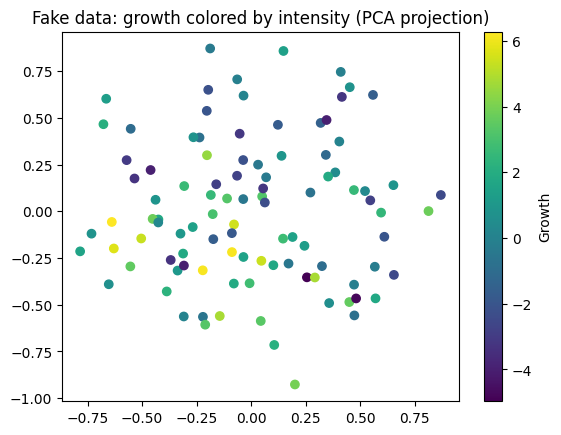

In [16]:
# -------------------------------------------------
# 7. (Optional) VISUALIZE GP PERFORMANCE (projected to 2D)
# -------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_data)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_data, cmap="viridis")
plt.title("Fake data: growth colored by intensity (PCA projection)")
plt.colorbar(label="Growth")
plt.show()

NameError: name 'X_train' is not defined